In [160]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

In [162]:
import sys
sys.path.append('../src')
from data import fetch_model_data
from model import evaluation
%aimport data.fetch_model_data
%aimport model.evaluation

# KNN

## Train Test Split

In [163]:
ip_address = '18.218.116.177'
raw = fetch_model_data.fetch_model_data(ip_address)

In [164]:
first_feature_set = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
    'ideol_range',
    'first_word_approp',
]

In [165]:
X, y = raw[first_feature_set], raw.third_reading
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

## Metric Selection

In [166]:
# ROC for overall model quality
# Accuracy for interpretability
# Precision (don't want to say a bill will pass and be wrong)

## Baseline KNN

In [167]:
knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train, y_train, return_train_score=True, scoring=['roc_auc', 'accuracy', 'precision'], cv=5)
evaluation.report_single_model_metrics(scores)

,metric,mean,std,in_sample
0,roc_auc,0.854294,0.015401,0.889328
1,accuracy,0.813994,0.015822,0.841558
2,precision,0.835279,0.013590,0.858045


In [168]:
# Perhaps a little overfit.
# Doing pretty well actually

## Tune Parameters

In [169]:
grid_results, best_params = evaluation.report_grid_results(X_train, y_train, KNeighborsClassifier(), param_grid={ 'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']})

In [170]:
grid_results.head()

,params,mean_test_score,std_test_score,mean_train_score,rank_test_score
26,"{'n_neighbors': 14, 'weights': 'uniform'}",0.864348,0.010223,0.887046,1
28,"{'n_neighbors': 15, 'weights': 'uniform'}",0.862880,0.009782,0.886229,2
24,"{'n_neighbors': 13, 'weights': 'uniform'}",0.862640,0.010087,0.889033,3
22,"{'n_neighbors': 12, 'weights': 'uniform'}",0.862252,0.011776,0.890352,4
18,"{'n_neighbors': 10, 'weights': 'uniform'}",0.861925,0.012948,0.893081,5


## All Features

In [172]:
evaluation.run_pipeline(raw, first_feature_set, KNeighborsClassifier, param_grid={ 'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']})

Best params: {'n_neighbors': 14, 'weights': 'uniform'}


,metric,mean,std,in_sample
0,roc_auc,0.864342,0.010218,0.887046
1,accuracy,0.824731,0.013989,0.828861
2,precision,0.836062,0.014828,0.841379


In [112]:
# all three metrics improved

## Different Features

In [138]:
second_feature_set = [
#     'author_ideology',
    'author_party',
#     'author_is_chair',
#     'author_years_sen',
#     'author_total_funding',
    'total_sponsors',
#     'sponsor_chairs',
#     'agg_funding_sponsors',
#     'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
#     'ideol_range',
#     'first_word_approp',
]

evaluation.run_pipeline(raw, second_feature_set)

,metric,mean,std,in_sample
0,roc_auc,0.836159,0.021920,0.859535
1,accuracy,0.811843,0.018503,0.817416
2,precision,0.832245,0.013618,0.836798


In [ ]:
# Every metric got worse
# Gap between in vs. out of sample got larger
    # Removing features made it more over fit (weird)

In [139]:
third_feature_set = [
    'author_ideology',
#     'author_party',
    'author_is_chair',
#     'author_years_sen',
#     'author_total_funding',
    'total_sponsors',
#     'sponsor_chairs',
#     'agg_funding_sponsors',
#     'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
#     'bipartisan',
    'ideol_range',
#     'first_word_approp',
]

evaluation.run_pipeline(raw, third_feature_set)

,metric,mean,std,in_sample
0,roc_auc,0.858328,0.010961,0.880467
1,accuracy,0.819004,0.014350,0.825999
2,precision,0.833739,0.010152,0.837001


In [ ]:
# Every metric got worse again
# STD of test metrics stayed very similar (maybe slightly worse)

## Tune Threshold

In [155]:
s = cross_validate(
    KNeighborsClassifier(**best_params),
    X_train,
    y_train,
    return_train_score=True,
    scoring=['roc_auc', 'accuracy', 'precision'],
    cv=5,
    metric_params={''}
)
evaluation.report_single_model_metrics(s)

,metric,mean,std,in_sample
0,roc_auc,0.864342,0.010218,0.887046
1,accuracy,0.824731,0.013989,0.828861
2,precision,0.836062,0.014828,0.841379


0.8214285714285714


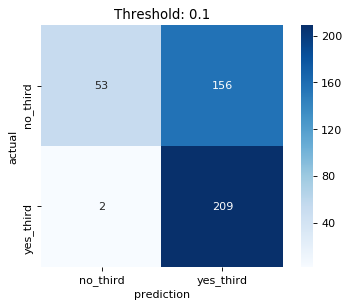

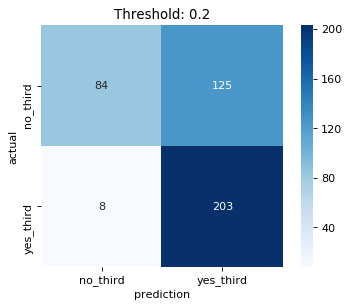

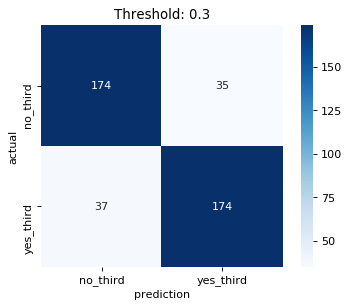

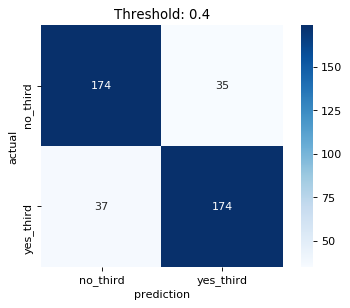

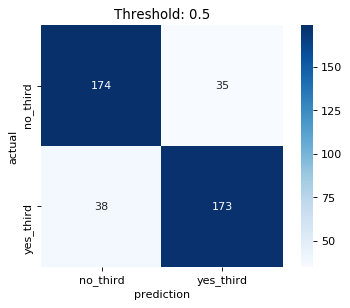

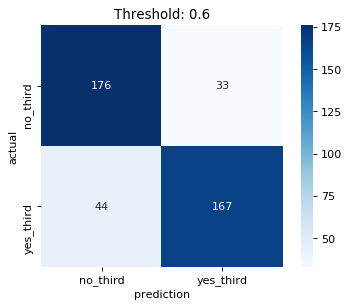

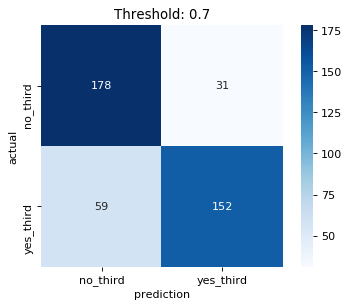

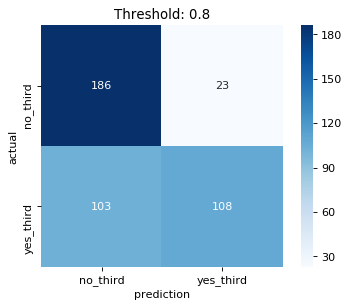

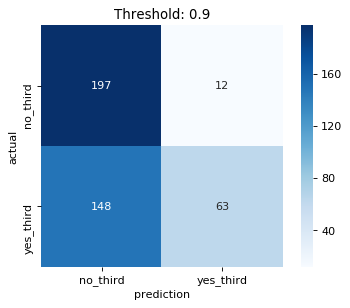

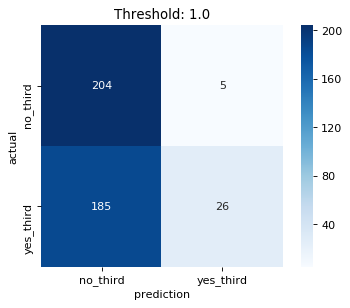

In [158]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)
knn = KNeighborsClassifier(**best_params)
knn.fit(X_tr, y_tr)
print(knn.score(X_val, y_val))
for t in [x / 10 for x in range(1, 11)]:
    evaluation.make_confusion_matrix(X_val, y_val, knn, ['no_third', 'yes_third'], f'Threshold: {t}', t)

In [ ]:
# Difficult to get precision better without exploding recall
# 0.4 actually looks like the best threshold

#### Conclusion: KNN with {'n_neighbors': 14, 'weights': 'uniform'} and threshold = 0.4